# Import necessary libraries and define configurations

In [1]:

import os
import pickle
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML

# Configurations
DATASET_DIR = "/kaggle/input/wesad-full-dataset/WESAD/"  # Adjust path
TEST_SIZE = 0.3  # 70:30 split
WINDOW_SIZE = 80  # 10 seconds at 4Hz (EDA sampling rate)
FILTER_CUTOFF = 0.1  # Low-pass filter cutoff frequency
OVERLAB = 40
MAX_TREES = 100  # Maximum number of trees for loss curve
OUTPUT_DIR = "/kaggle/working/outputs"  # Output directory for saved figures

# Define helper functions for filtering and feature extraction

In [2]:

def low_pass_filter(signal, cutoff=FILTER_CUTOFF, fs=4, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

def extract_features(gsr_signal):
    gsr_signal = np.squeeze(gsr_signal)
    filtered_signal = low_pass_filter(gsr_signal)
    
    # Time-domain features
    mean_val = np.mean(filtered_signal)
    std_dev = np.std(filtered_signal)
    min_val = np.min(filtered_signal)
    max_val = np.max(filtered_signal)
    skewness = skew(filtered_signal)
    kurt = kurtosis(filtered_signal)
    
    # Frequency-domain features
    freqs, psd = welch(filtered_signal, fs=4, nperseg=min(256, len(filtered_signal)))
    dominant_freq = freqs[np.argmax(psd)]
    total_power = np.sum(psd)
    
    return [mean_val, std_dev, min_val, max_val, skewness, kurt, dominant_freq, total_power]


# Load and preprocess the WESAD dataset


In [3]:

def load_and_preprocess_data():
    all_subjects_data = []
    stress_count = 0
    non_stress_count = 0
    all_eda_values = []

    for subject in os.listdir(DATASET_DIR):
        subject_path = os.path.join(DATASET_DIR, subject, f"{subject}.pkl")
        if os.path.exists(subject_path):
            print(f"Loading subject: {subject}")  # Added line to define loading subject
            with open(subject_path, 'rb') as file:
                data = pickle.load(file, encoding='latin1')

            signal_data = data['signal']['wrist']
            labels = data['label']

            gsr_signal = signal_data['EDA']
            all_eda_values.extend(gsr_signal.flatten())

            window_stride = 20
            for i in range(0, len(gsr_signal) - window_stride, window_stride):
                label = labels[i]
                if label == 1:
                    stress_count += 1
                else:
                    non_stress_count += 1

                features = extract_features(gsr_signal[i:i + window_stride])
                all_subjects_data.append({
                    'Features': features,
                    'Label': label
                })

    average_eda = np.mean(all_eda_values)
    print(f"Average EDA Signal Value: {average_eda:.4f}")

    return all_subjects_data, stress_count, non_stress_count

data_list, stress_count, non_stress_count = load_and_preprocess_data()

Loading subject: S14
Loading subject: S11
Loading subject: S13
Loading subject: S10
Loading subject: S8
Loading subject: S5
Loading subject: S7
Loading subject: S9
Loading subject: S15
Loading subject: S2
Loading subject: S6
Loading subject: S3
Loading subject: S4
Loading subject: S16
Loading subject: S17
Average EDA Signal Value: 1.8018


# Convert data to DataFrame, normalize features, apply SMOTE, and split into train/test sets

In [4]:

df = pd.DataFrame([x['Features'] for x in data_list])
df['Label'] = [x['Label'] for x in data_list]
df.dropna(inplace=True)

# Rename columns for clarity
df.columns = ['Mean_GSR', 'Std_Dev_GSR', 'Min_GSR', 'Max_GSR', 'Skewness', 'Kurtosis', 'Dominant_Frequency', 'Total_Power', 'Label']

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=['Label']))
y = df['Label']

# Balance Data (SMOTE)
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

# Train the Random Forest model and calculate loss curves

In [5]:

train_losses = []
test_losses = []
n_estimators_range = range(1, MAX_TREES + 1, 1)  # Evaluate every tree for smoother curve

for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=10, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    
    # Calculate log loss for training and test sets
    train_proba = model.predict_proba(X_train)
    test_proba = model.predict_proba(X_test)
    train_loss = log_loss(y_train, train_proba)
    test_loss = log_loss(y_test, test_proba)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Final Model Training
model = RandomForestClassifier(n_estimators=MAX_TREES, max_depth=10, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Print initial evaluation metrics

In [6]:

# 1. Stress Samples
print("\n1. Stress Samples After Windowing:", stress_count)

# 2. Non-Stress Samples
print("2. Non-Stress Samples After Windowing:", non_stress_count)


1. Stress Samples After Windowing: 192
2. Non-Stress Samples After Windowing: 17174


# Plot EDA Signal Before and After Filtering


Plotting EDA Signal Before and After Filtering (Plot 1/6):


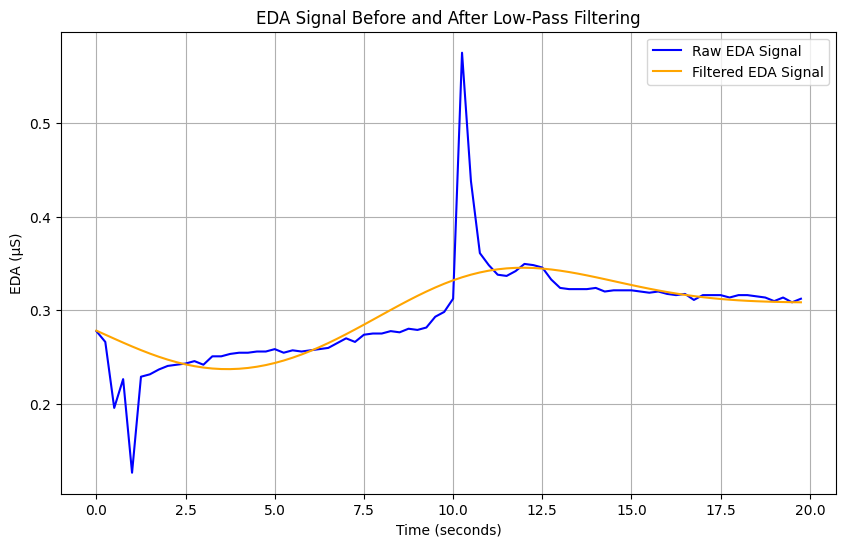

Saved EDA Signal Plot to /kaggle/working/outputs/eda_signal.png


In [7]:

print("\nPlotting EDA Signal Before and After Filtering (Plot 1/6):")
# Use the first window's signal from the first subject for plotting
first_subject = os.listdir(DATASET_DIR)[0]
first_path = os.path.join(DATASET_DIR, first_subject, f"{first_subject}.pkl")
with open(first_path, 'rb') as file:
    data = pickle.load(file, encoding='latin1')
gsr_signal = data['signal']['wrist']['EDA']
raw_signal = np.squeeze(gsr_signal[:WINDOW_SIZE])
filtered_signal = low_pass_filter(raw_signal)
time = np.arange(0, len(raw_signal)) / 4  # Time in seconds (4Hz sampling rate)

plt.figure(figsize=(10, 6))
plt.plot(time, raw_signal, label='Raw EDA Signal', color='blue')
plt.plot(time, filtered_signal, label='Filtered EDA Signal', color='orange')
plt.title('EDA Signal Before and After Low-Pass Filtering')
plt.xlabel('Time (seconds)')
plt.ylabel('EDA (µS)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, 'eda_signal.png'))
plt.show()
plt.close()
print(f"Saved EDA Signal Plot to {os.path.join(OUTPUT_DIR, 'eda_signal.png')}")

# Plot Class Distribution Before and After SMOTE


Plotting Class Distribution Before and After SMOTE (Plot 2/6):


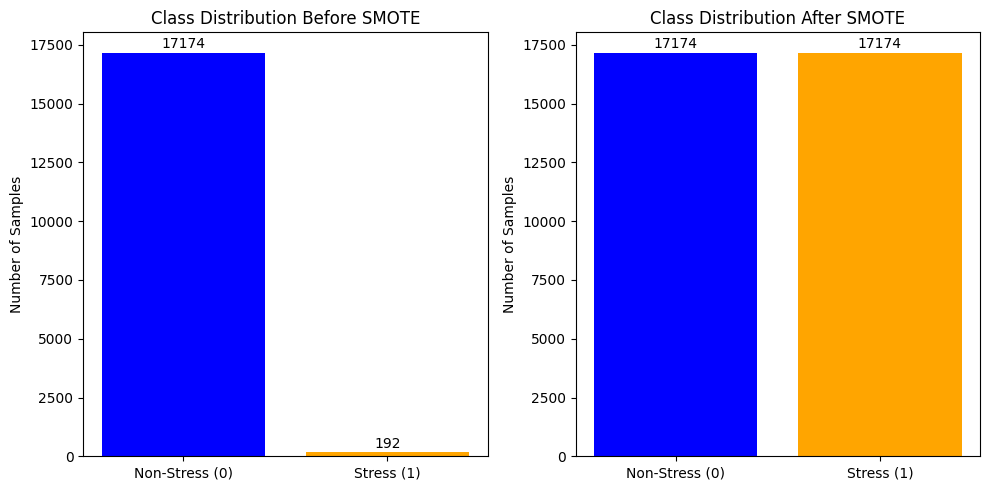

Saved Class Distribution Plot to /kaggle/working/outputs/class_distribution.png


In [8]:

print("\nPlotting Class Distribution Before and After SMOTE (Plot 2/6):")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Before SMOTE
non_stress_before = len(df[df['Label'] == 0])
stress_before = len(df[df['Label'] == 1])
ax1.bar(['Non-Stress (0)', 'Stress (1)'], [non_stress_before, stress_before], color=['blue', 'orange'])
ax1.set_title('Class Distribution Before SMOTE')
ax1.set_ylabel('Number of Samples')
for i, v in enumerate([non_stress_before, stress_before]):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom')

# After SMOTE
non_stress_after = len(y[y == 0])
stress_after = len(y[y == 1])
ax2.bar(['Non-Stress (0)', 'Stress (1)'], [non_stress_after, stress_after], color=['blue', 'orange'])
ax2.set_title('Class Distribution After SMOTE')
ax2.set_ylabel('Number of Samples')
for i, v in enumerate([non_stress_after, stress_after]):
    ax2.text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'class_distribution.png'))
plt.show()
plt.close()
print(f"Saved Class Distribution Plot to {os.path.join(OUTPUT_DIR, 'class_distribution.png')}")

#  Confusion Matrix 
#  Plot Loss Curve


3. Training Accuracy: 0.9664
4. Test Accuracy: 0.9647

5. Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5153
           1       0.93      1.00      0.97      5152

    accuracy                           0.96     10305
   macro avg       0.97      0.96      0.96     10305
weighted avg       0.97      0.96      0.96     10305


6. Confusion Matrix:
 [[4790  363]
 [   1 5151]]

7. Displaying Confusion Matrix Plot (Plot 3/6):


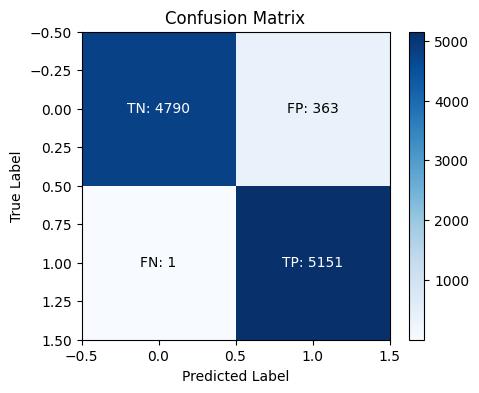


8. Displaying Loss Curve Plot (Plot 4/6):


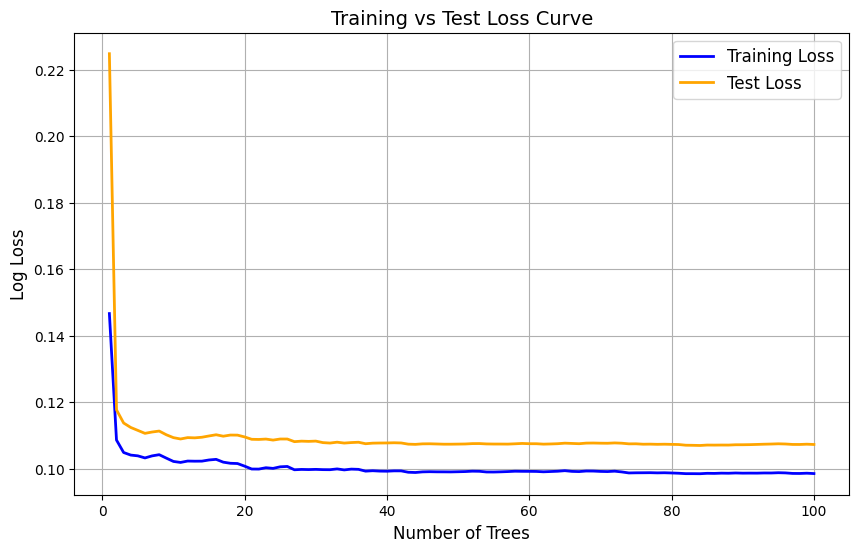

In [9]:
# 3. Training Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"\n3. Training Accuracy: {train_accuracy:.4f}")

# 4. Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"4. Test Accuracy: {test_accuracy:.4f}")

# 5. Classification Report
print("\n5. Classification Report:")
print(classification_report(y_test, y_test_pred))

# 6. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\n6. Confusion Matrix:\n", conf_matrix)

# 7. Plot Confusion Matrix
print("\n7. Displaying Confusion Matrix Plot (Plot 3/6):")
plt.figure(figsize=(5, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == 0 and j == 0:
            plt.text(j, i, f'TN: {conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
        elif i == 0 and j == 1:
            plt.text(j, i, f'FP: {conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
        elif i == 1 and j == 0:
            plt.text(j, i, f'FN: {conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
        elif i == 1 and j == 1:
            plt.text(j, i, f'TP: {conf_matrix[i, j]}', ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()
plt.close()

# 8. Plot Loss Curve
print("\n8. Displaying Loss Curve Plot (Plot 4/6):")
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(n_estimators_range, test_losses, label='Test Loss', color='orange', linewidth=2)
plt.title('Training vs Test Loss Curve', fontsize=14)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Log Loss', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'))
plt.show()
plt.close()

#  Loss Analysis and 
#  Feature Statistics for Stressed and Non-Stressed Samples

In [10]:

final_train_loss = train_losses[-1]
final_test_loss = test_losses[-1]
print("\n9. Loss Analysis:")
if final_train_loss < final_test_loss and (final_test_loss - final_train_loss) < 0.5:
    print("The model shows good generalization. The training loss curve is consistently below the test loss curve, but the gap is not too large, indicating minimal overfitting.")
elif final_train_loss < final_test_loss and (final_test_loss - final_train_loss) >= 0.5:
    print("The model may be overfitting. The training loss curve is significantly lower than the test loss curve, suggesting the model fits the training data too closely.")
else:
    print("The model shows unusual behavior. The test loss curve is below the training loss curve, which is uncommon and may indicate issues with the data split or model configuration.")


stressed_df = df[df['Label'] == 1]
non_stressed_df = df[df['Label'] == 0]
print("\n10. Feature Statistics for Stressed Samples (Label = 1):")
print(stressed_df.describe())
print("\nFeature Statistics for Non-Stressed Samples (Label = 0):")
print(non_stressed_df.describe())


9. Loss Analysis:
The model shows good generalization. The training loss curve is consistently below the test loss curve, but the gap is not too large, indicating minimal overfitting.

10. Feature Statistics for Stressed Samples (Label = 1):
         Mean_GSR  Std_Dev_GSR     Min_GSR     Max_GSR    Skewness  \
count  192.000000   192.000000  192.000000  192.000000  192.000000   
mean     0.317407     0.001485    0.315275    0.319981    0.168960   
std      0.019006     0.004046    0.017196    0.023113    0.635790   
min      0.286820     0.000011    0.286003    0.286898   -1.459116   
25%      0.310293     0.000270    0.308624    0.311382   -0.301582   
50%      0.314479     0.000503    0.313695    0.314982    0.252095   
75%      0.319100     0.000998    0.317959    0.320105    0.620159   
max      0.412155     0.036461    0.370275    0.482683    1.406140   

         Kurtosis  Dominant_Frequency   Total_Power  Label  
count  192.000000        1.920000e+02  1.920000e+02  192.0  
mean

#  GUI for Stress Prediction

In [11]:

feature_names = [
    "Mean GSR", "Std Dev GSR", "Min GSR", "Max GSR", 
    "Skewness", "Kurtosis", "Dominant Frequency", "Total Power"
]

# Create input widgets for the 8 feature values
input_widgets = [widgets.FloatText(
    description=name + ":", 
    value=0.0, 
    style={'description_width': 'initial'},
    layout={'width': '400px'}
) for name in feature_names]

# Create a button to trigger prediction
predict_button = widgets.Button(
    description="Predict Stress",
    button_style='success',
    tooltip='Click to predict stress level',
    layout={'width': '200px', 'margin': '10px 0'}
)

# Create an output widget to display the result
output = widgets.Output()

# Define the prediction function
def on_predict_button_clicked(b):
    with output:
        output.clear_output()
        # Collect input values
        input_values = []
        for widget in input_widgets:
            try:
                value = float(widget.value)
                input_values.append(value)
            except ValueError:
                display(HTML(f"<p style='color: #e74c3c;'>Invalid input for {widget.description}. Please enter a valid number.</p>"))
                return
        
        # Create a DataFrame with feature names to match training
        features = pd.DataFrame([input_values], columns=[0, 1, 2, 3, 4, 5, 6, 7])
        
        try:
            # Scale the features
            scaled_features = scaler.transform(features)
            # Make prediction
            prediction = model.predict(scaled_features)[0]
            probability = model.predict_proba(scaled_features)[0]
            
            # Determine result and confidence
            result = "Stressed" if prediction == 1 else "Not Stressed"
            confidence = probability[1] if prediction == 1 else probability[0]
            
            # Display styled result
            color = "#e74c3c" if prediction == 1 else "#2ecc71"
            display(HTML(f"""
                <div style='background-color: #f5f5f5; padding: 15px; border-radius: 5px;'>
                    <h3 style='color: {color}; margin: 0;'>Prediction: {result}</h3>
                    <p style='color: #333; margin: 5px 0 0 0;'>Confidence: {confidence:.2%}</p>
                </div>
            """))
        except Exception as e:
            display(HTML(f"<p style='color: #e74c3c;'>Error in prediction: {str(e)}</p>"))

# Connect the button to the prediction function
predict_button.on_click(on_predict_button_clicked)

# Display the GUI
print("\n11. Displaying Stress Prediction GUI (5/6):")
display(HTML("""
    <h2 style='color: #2c3e50;'>Stress Prediction GUI</h2>
    <p style='color: #34495e;'>Enter the 8 GSR feature values below and click 'Predict Stress' to see the result.</p>
"""))
for widget in input_widgets:
    display(widget)
display(predict_button)
display(output)


11. Displaying Stress Prediction GUI (5/6):


FloatText(value=0.0, description='Mean GSR:', layout=Layout(width='400px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='Std Dev GSR:', layout=Layout(width='400px'), style=DescriptionStyle(descript…

FloatText(value=0.0, description='Min GSR:', layout=Layout(width='400px'), style=DescriptionStyle(description_…

FloatText(value=0.0, description='Max GSR:', layout=Layout(width='400px'), style=DescriptionStyle(description_…

FloatText(value=0.0, description='Skewness:', layout=Layout(width='400px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='Kurtosis:', layout=Layout(width='400px'), style=DescriptionStyle(description…

FloatText(value=0.0, description='Dominant Frequency:', layout=Layout(width='400px'), style=DescriptionStyle(d…

FloatText(value=0.0, description='Total Power:', layout=Layout(width='400px'), style=DescriptionStyle(descript…

Button(button_style='success', description='Predict Stress', layout=Layout(margin='10px 0', width='200px'), st…

Output()